## analyze transfer

In [ ]:
import os
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt

HOME = "."

SCALE_LIST = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2]
DEFAULT_LENPOLE = 0.5
DEFAULT_MASSCART = 1.0
DEFAULT_MASSPOLE = 0.1

=== Building reward matrix for trial 2 ===


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.17276274606320036s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Batch computation too fast (0.02716827392578125s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Batch computation too fast (0.031097412109375s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Batch computation too fast (0.03605222702026367s.) Setting batch_size=1

Saved (1000, 1000) matrix to: /mnt/home/tianyuez/MD-MBTL/MBTL/control-tasks/Data/transfer_reward_matrix_trial2.npy


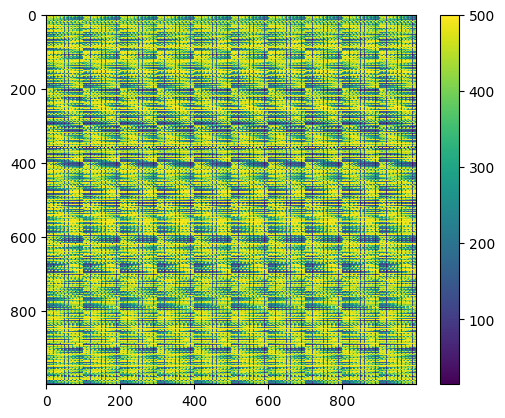

In [7]:
def parse_context_index(idx):
    lenpole_idx   = idx % 10
    masscart_idx  = (idx // 10) % 10
    masspole_idx  = (idx // 100) % 10
    return lenpole_idx, masscart_idx, masspole_idx

def get_numeric_values(lenpole_idx, masscart_idx, masspole_idx):
    ln_val = round(DEFAULT_LENPOLE  * SCALE_LIST[lenpole_idx], 2)
    mc_val = round(DEFAULT_MASSCART * SCALE_LIST[masscart_idx], 2)
    mp_val = round(DEFAULT_MASSPOLE * SCALE_LIST[masspole_idx], 2)
    return ln_val, mc_val, mp_val

def get_reward(i, j, trial):
    # i, j are source/target context indices in [0..999]
    i_lenpole_idx, i_masscart_idx, i_masspole_idx = parse_context_index(i)
    ln_i, mc_i, mp_i = get_numeric_values(i_lenpole_idx, i_masscart_idx, i_masspole_idx)

    source_dir = (
        f"{HOME}/results/cartpole/"
        f"masscart{mc_i}-lenpole{ln_i}-masspole{mp_i}-"
        f"force10.00-update0.02-PPO-trial{trial}"
    )

    j_lenpole_idx, j_masscart_idx, j_masspole_idx = parse_context_index(j)
    ln_j, mc_j, mp_j = get_numeric_values(j_lenpole_idx, j_masscart_idx, j_masspole_idx)

    target_dir = (
        f"{source_dir}/transfer_masscart{mc_j}-lenpole{ln_j}-masspole{mp_j}-"
        f"force10.00-update0.02-PPO-trial{trial}"
    )
    reward_file = os.path.join(target_dir, "test_reward.csv")

    if os.path.exists(reward_file):
        df = pd.read_csv(reward_file, header=None)
        return df[0].mean()
    else:
        return np.nan
        
LENGTH = 1000
for trial in range(3):
    print(f"=== Building reward matrix for trial {trial} ===")

    # Create a list of all (i, j) pairs
    tasks = [(i, j) for i in range(LENGTH) for j in range(LENGTH)]
    
    # Using Parallel: set n_jobs to the number of cores you want to use
    results = Parallel(n_jobs=8, verbose=10)(
        delayed(get_reward)(i, j, trial) for (i, j) in tasks
    )
    
    # 'results' is a flat list of length 1,000*1,000 = 1e6
    # reshape into (1000, 1000)
    reward_matrix = np.reshape(results, (LENGTH, LENGTH))
    out_path = os.path.join(HOME, f"data/transfer_reward_matrix_trial{trial}.npy")
    np.save(out_path, reward_matrix)
    print(f"Saved {reward_matrix.shape} matrix to: {out_path}")

    plt.clf()
    plt.imshow(reward_matrix, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.show()


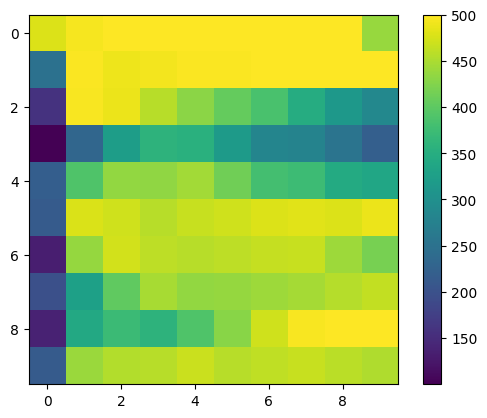

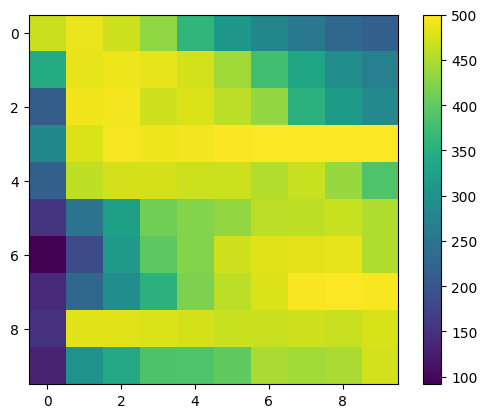

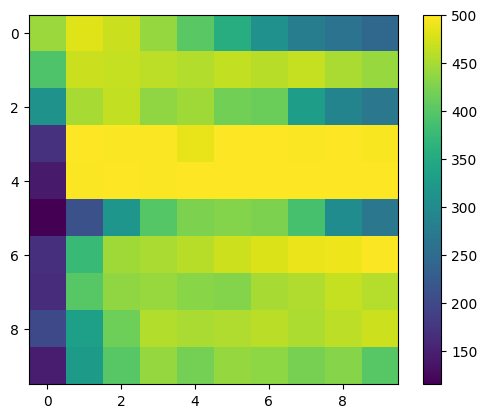

In [15]:
for trial in range(3):
    out_path = os.path.join(HOME, f"data/transfer_reward_matrix_trial{trial}.npy")
    reward_matrix = np.load(out_path)[50:60, 50:60]
    plt.clf()
    plt.imshow(reward_matrix, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.show()
